In [1]:
import glob
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import torch

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import CacheDataset, DataLoader, Dataset, partition_dataset
from monai.inferers import sliding_window_inference
from monai.losses import DiceLoss
from monai.metrics import compute_meandice
from monai.networks.layers import Norm
from monai.networks.nets import UNet
from monai.transforms import (
    AsDiscrete,
    AddChanneld,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,
    ToTensord,
    CenterSpatialCropd
)
from monai.utils import first, set_determinism

print_config()

MONAI version: 0.4.0
Numpy version: 1.19.2
Pytorch version: 1.7.1
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 0563a4467fa602feca92d91c7f47261868d171a1

Optional dependencies:
Pytorch Ignite version: 0.4.2
Nibabel version: 3.2.1
scikit-image version: 0.18.1
Pillow version: 8.0.1
Tensorboard version: 2.4.0
gdown version: 3.12.2
TorchVision version: 0.8.2
ITK version: 5.1.2
tqdm version: 4.55.0
lmdb version: 1.0.0
psutil version: 5.8.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [2]:
os.environ["MONAI_DATA_DIRECTORY"] = "./data"
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

./data


In [3]:
data_dir = os.path.join(root_dir, "nifti_data")
train_images = sorted(glob.glob(os.path.join(data_dir, "image", "*.nii.gz")))
train_labels = sorted(glob.glob(os.path.join(data_dir, "mask", "*.nii.gz")))
data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]

In [4]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        #Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        #Orientationd(keys=["image", "label"], axcodes="RAS"),
        ScaleIntensityRanged(
            keys=["image"], a_min=0.0, a_max=1000, b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        #CenterSpatialCropd(keys=["image", "label"],roi_size = (192, 192, 16)),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(128, 128, 16),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        # user can also add other random transforms
        # RandAffined(keys=['image', 'label'], mode=('bilinear', 'nearest'), prob=1.0, spatial_size=(96, 96, 96),
        #             rotate_range=(0, 0, np.pi/15), scale_range=(0.1, 0.1, 0.1)),
        ToTensord(keys=["image", "label"]),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        #Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        #Orientationd(keys=["image", "label"], axcodes="RAS"),
        ScaleIntensityRanged(
            keys=["image"], a_min=0, a_max=1000, b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        ToTensord(keys=["image", "label"]),
    ] 
)

test_transforms = Compose([
                  LoadImaged(keys=["image", "label"]), 
                  AddChanneld(keys=["image", "label"]), 
                  CropForegroundd(keys=["image", "label"], source_key="image"),
                  ToTensord(keys=["image", "label"])]
                  )

In [5]:
train_data, val_data, test_data = partition_dataset(data_dicts, ratios = [0.8, 0.1, 0.1], shuffle = True)

train_ds = CacheDataset(data=train_data, transform=train_transforms, cache_rate=1.0, num_workers=0)
val_ds = CacheDataset(data=val_data, transform=val_transforms, cache_rate=1.0, num_workers=0)
test_ds = CacheDataset(data=val_data, transform=test_transforms, cache_rate=1.0, num_workers=0)

print('\n'+'Training set:', len(train_data), 'subjects')
print('Validation set:', len(val_data), 'subjects')
print('Validation set:', len(test_data), 'subjects')

100%|██████████| 4/4 [00:01<00:00,  2.71it/s]
Training set: 32 subjects
Validation set: 4 subjects
Validation set: 4 subjects



In [6]:
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=0)
test_loader = DataLoader(test_ds, batch_size=1, num_workers=0)

In [7]:
### custom defined visualization function
def plot_image_and_mask(imgset, maskset):
    fig, axs = plt.subplots(len(imgset[0,0,:])-1,2, figsize=(10,100))
    count = 0
    for i in range(len(imgset[0,0,:])-1):
        axs[count][0].title.set_text("MRI T2 WI rectal") # set title
        axs[count][0].imshow(imgset[:,:,i],cmap='gray') # show MRI 
        axs[count][1].title.set_text("Mask") # plot title on the mask 
        axs[count][1].imshow(maskset[:,:,i]) # Show corresponding mask
        count += 1
    fig.tight_layout()

image shape: torch.Size([128, 128, 16]), label shape: torch.Size([128, 128, 16])


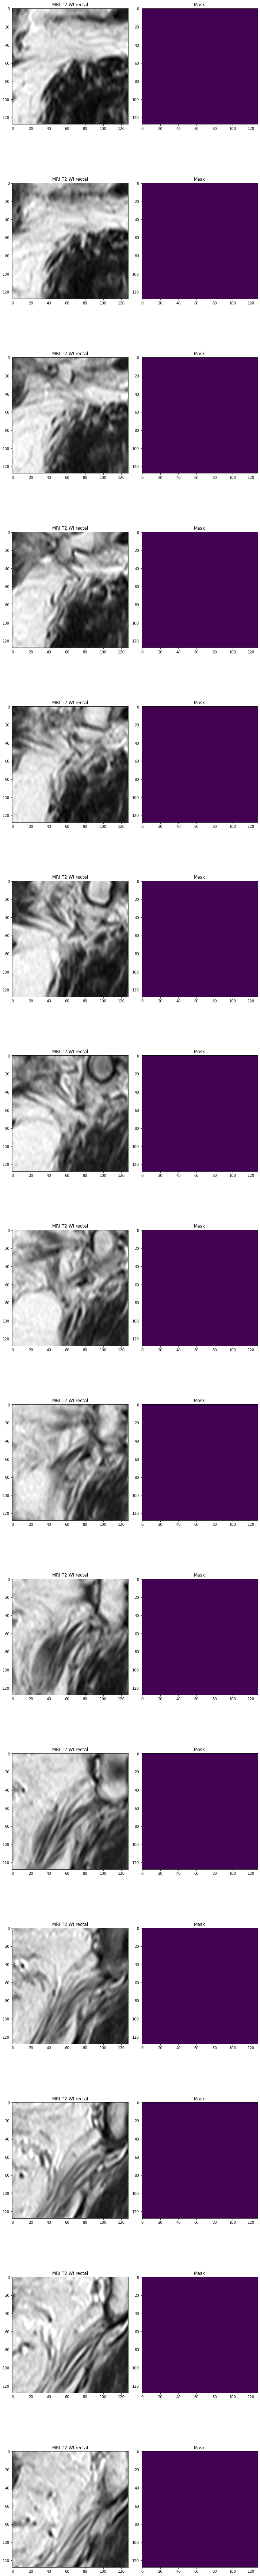

In [8]:
batch = next(iter(train_loader))
image, label = (batch["image"][0][0], batch["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")

### plot a batch of training images and masks 
plot_image_and_mask(image, label)

In [9]:
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0")
model = UNet(
    dimensions=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
    dropout=0.2
).to(device)
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.AdamW(model.parameters(), 1e-4)

In [10]:
from torchsummaryX import summary
temp = torch.zeros((8, 1, 128, 128, 16), device=device)
summary(model, temp)

                                                           Kernel Shape  \
Layer                                                                     
0_model.0.Conv3d_residual                              [1, 16, 3, 3, 3]   
1_model.0.conv.unit0.Conv3d_conv                       [1, 16, 3, 3, 3]   
2_model.0.conv.unit0.adn.BatchNorm3d_N                             [16]   
3_model.0.conv.unit0.adn.Dropout_D                                    -   
4_model.0.conv.unit0.adn.PReLU_A                                    [1]   
5_model.0.conv.unit1.Conv3d_conv                      [16, 16, 3, 3, 3]   
6_model.0.conv.unit1.adn.BatchNorm3d_N                             [16]   
7_model.0.conv.unit1.adn.Dropout_D                                    -   
8_model.0.conv.unit1.adn.PReLU_A                                    [1]   
9_model.1.submodule.0.Conv3d_residual                 [16, 32, 3, 3, 3]   
10_model.1.submodule.0.conv.unit0.Conv3d_conv         [16, 32, 3, 3, 3]   
11_model.1.submodule.0.co

Kernel Shape  \
Layer                                                      
0_model.0.Conv3d_residual               [1, 16, 3, 3, 3]   
1_model.0.conv.unit0.Conv3d_conv        [1, 16, 3, 3, 3]   
2_model.0.conv.unit0.adn.BatchNorm3d_N              [16]   
3_model.0.conv.unit0.adn.Dropout_D                     -   
4_model.0.conv.unit0.adn.PReLU_A                     [1]   
...                                                  ...   
73_model.2.0.adn.BatchNorm3d_N                       [2]   
74_model.2.0.adn.Dropout_D                             -   
75_model.2.0.adn.PReLU_A                             [1]   
76_model.2.1.Identity_residual                         -   
77_model.2.1.conv.unit0.Conv3d_conv      [2, 2, 3, 3, 3]   

                                                Output Shape  Params  \
Layer                                                                  
0_model.0.Conv3d_residual                 [8, 16, 64, 64, 8]   448.0   
1_model.0.conv.unit0.Conv3d_conv          [8, 16, 64, 64, 8]   448.0   
2_model.0.conv.unit0.adn.BatchNorm3d_N    [8, 16, 64, 64, 8]    32.0   
3_model.0.conv.unit0.adn.Dropout_D        [8, 16, 64, 64, 8]     NaN   
4_model.0.conv.unit0.adn.PReLU_A          [8, 16, 64, 64, 8]     1.0   
...                                                      ...     ...   
73_model.2.0.adn.BatchNorm3d_N          [8, 2, 128, 128, 16]     4.0   
74_model.2.0.adn.Dropout_D              [8, 2, 128, 128, 16]     NaN   
75_model.2.0.adn.PReLU_A                [8, 2, 128, 128, 16]     1.0   
76_model.2.1.Identity_residual          [8, 2, 128, 128, 16]     NaN   
77_model.2.1.conv.unit0.Conv3d_conv     [8, 2, 128, 128, 16]   110.0   

                                         Mult-Adds  
Layer                                               
0_model.0.Conv3d_residual               14155776.0  
1_model.0.conv.unit0.Conv3d_conv        14155776.0  
2_model.0.conv.unit0.adn.BatchNorm3d_N        16.0  
3_model.0.conv.unit0.adn.Dropout_D             NaN  
4_model.0.conv.unit0.adn.PReLU_A               1.0  
...                                            ...  
73_model.2.0.adn.BatchNorm3d_N                 2.0  
74_model.2.0.adn.Dropout_D                     NaN  
75_model.2.0.adn.PReLU_A                       1.0  
76_model.2.1.Identity_residual                 NaN  
77_model.2.1.conv.unit0.Conv3d_conv     28311552.0  

[78 rows x 4 columns]

In [11]:
epoch_num = 1000
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = list()
metric_values = list()
post_pred = AsDiscrete(argmax=True, to_onehot=True, n_classes=2)
post_label = AsDiscrete(to_onehot=True, n_classes=2)

for epoch in range(epoch_num):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{epoch_num}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            metric_sum = 0.0
            metric_count = 0
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                roi_size = (128, 128, 16)
                sw_batch_size = 1
                val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
                val_outputs = post_pred(val_outputs)
                val_labels = post_label(val_labels)
                value = compute_meandice(
                    y_pred=val_outputs,
                    y=val_labels,
                    include_background=False,
                )
                metric_count += len(value)
                metric_sum += value.sum().item()
            metric = metric_sum / metric_count
            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} at epoch: {best_metric_epoch}"
            )

in_loss: 0.3167
4/4, train_loss: 0.3171
epoch 898 average loss: 0.3027
current epoch: 898 current mean dice: 0.1220
best mean dice: 0.1736 at epoch: 824
----------
epoch 899/1000
1/4, train_loss: 0.2561
2/4, train_loss: 0.3256
3/4, train_loss: 0.3107
4/4, train_loss: 0.2553
epoch 899 average loss: 0.2869
----------
epoch 900/1000
1/4, train_loss: 0.2800
2/4, train_loss: 0.2919
3/4, train_loss: 0.3429
4/4, train_loss: 0.2768
epoch 900 average loss: 0.2979
current epoch: 900 current mean dice: 0.1239
best mean dice: 0.1736 at epoch: 824
----------
epoch 901/1000
1/4, train_loss: 0.2341
2/4, train_loss: 0.3109
3/4, train_loss: 0.3330
4/4, train_loss: 0.2716
epoch 901 average loss: 0.2874
----------
epoch 902/1000
1/4, train_loss: 0.3028
2/4, train_loss: 0.3283
3/4, train_loss: 0.3234
4/4, train_loss: 0.2405
epoch 902 average loss: 0.2987
current epoch: 902 current mean dice: 0.1615
best mean dice: 0.1736 at epoch: 824
----------
epoch 903/1000
1/4, train_loss: 0.3447
2/4, train_loss: 0.28

In [12]:
print(f"train completed, best_metric: {best_metric:.4f}  at epoch: {best_metric_epoch}")

train completed, best_metric: 0.1809  at epoch: 916


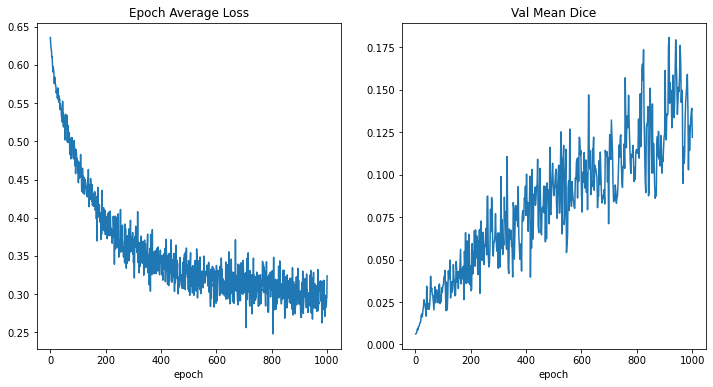

In [13]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

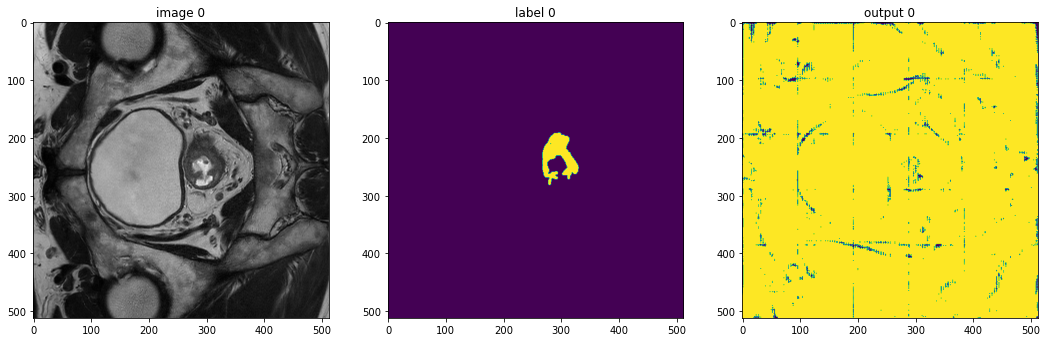

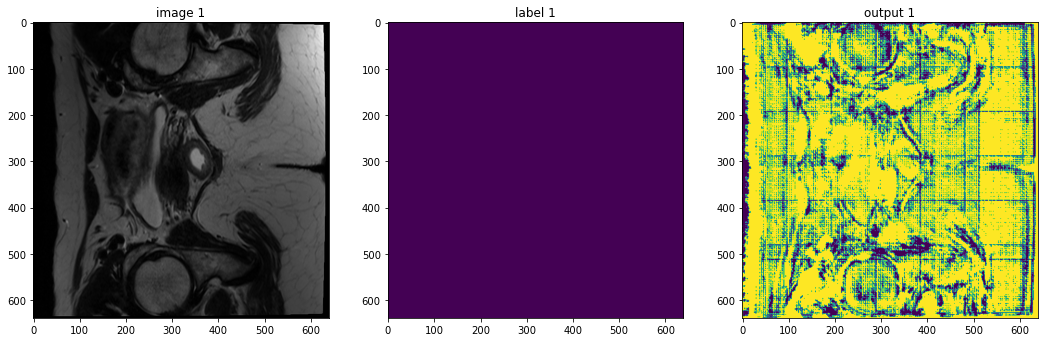

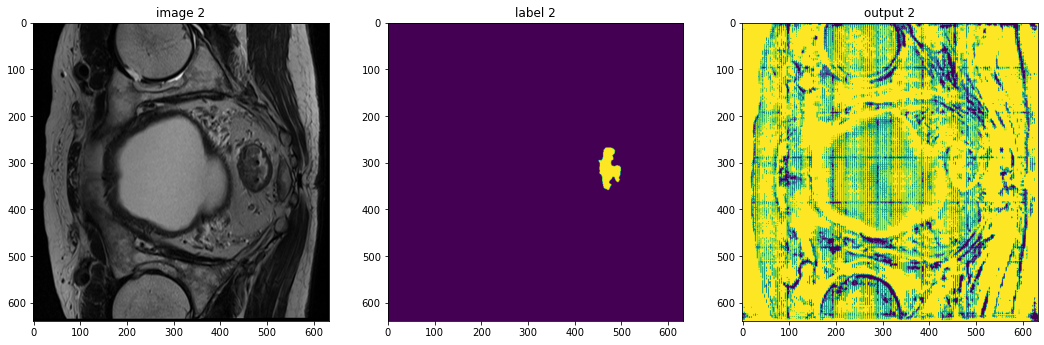

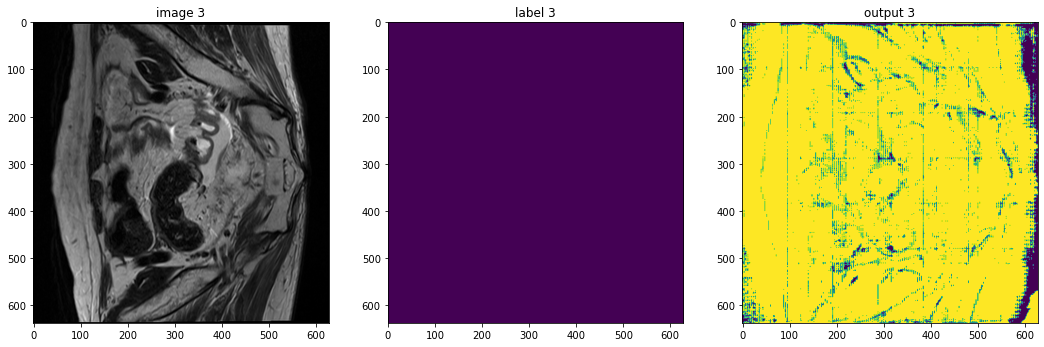

In [14]:
from random import *
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
with torch.no_grad():
    for i, test_data in enumerate(test_loader):
        roi_size = (128, 128, 16)
        sw_batch_size = 1
        test_outputs = sliding_window_inference(
                        test_data["image"].to(device), roi_size, sw_batch_size, model)
        # plot the slice [:, :, rand]
        j = randint(0, len(test_data["image"][0,0,0,0,:])-1)
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(test_data["image"][0, 0, :, :, j], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(test_data["label"][0, 0, :, :, j])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(test_outputs, dim=1).detach().cpu()[0, :, :, j])
        plt.show()